##   Some tests with pgpointcloud

- LAS files are intractable for subsetting and visualisation without LASTools or Terrasolid or Bentley Map (or similar) which are awesome but costly.
- Further, LAS files don't really let us store all manner of things along with the data, for example we already have issues storing digitised waveforms with the ACT dataset
- so what can we do? Here are some experiments with PostGIS-pointcloud, one approach to point cloud data management

Some things about this exercise:
- I am a postGIS/pgpointcloud n00b. An SQL ninja could probably do a lot better than this and a lot faster!
- The data set used here has ~975 000 000 points in it
- made from 16 ACT 8pt tiles (no waveform data, because stuff)
- ingested using a PDAL pipeline (http://pdal.io)
- LAS storage is ~30 GB
- PG-pointcloud table is ~12 GB, so reasonably similar to .LAZ
- there are 126 000 'patches' containing 5 000 points each
- patches are the primary query tool, so we index over ... rows, which are arranged in a quasi-space-filling-curve
- tradeoff between number of points in patch, and number of rows in DB
- but generally speaking, scalable (nearly... research shows that we will hit a limit before 20 billion points)


### Gathering modules

In [2]:
import os

import psycopg2 as ppg
import numpy as np
import ast
from osgeo import ogr

import shapely as sp
from shapely.geometry import Point,Polygon,asShape
from shapely.wkt import loads as wkt_loads
from shapely import speedups


import cartopy as cp
import cartopy.crs as ccrs

import pandas as pd
import pandas.io.sql as pdsql

import geopandas as gp

from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

import fiona

from descartes import PolygonPatch

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
speedups.available

True

In [4]:
speedups.enable()

## Making a postgres connection with psycopg2

In [5]:
#  PGPASSWORD=pointy_cloudy psql -h localhost -d pcbm_pc -U pcbm
pg_connection = "dbname=pcbm_pc user=pcbm password=pointy_cloudy host=130.56.244.246"
conn = ppg.connect(pg_connection)
cursor = conn.cursor()

### First query for some blocks - this gets them all!

In [7]:
#blocks_query = "SELECT pa::geometry(Polygon, 28355) AS geom, PC_PatchAvg(pa, 'Z') AS elevation, id FROM act_patches;"

blocks_query = "SELECT st_astext(PC_envelope(pa)::geometry(Polygon, 28355)) AS geom, PC_PatchAvg(pa, 'Z') AS elevation, id FROM act8pt_16tiles_pc;"

%time blks = pdsql.read_sql(blocks_query, conn)

CPU times: user 585 ms, sys: 390 ms, total: 975 ms
Wall time: 2min 6s


### Ingest data into a GeoPandas frame

In [10]:
blocks_query = "SELECT pa::geometry(Polygon, 28355) AS geom, PC_PatchAvg(pa, 'Z') AS elevation, id FROM act8pt_16tiles_pc where PC_PatchAvg(pa, 'Z') > 800;"

%time thepatches = gp.read_postgis(blocks_query, conn)

CPU times: user 19.9 ms, sys: 4.36 ms, total: 24.3 ms
Wall time: 46.5 s


In [11]:
thepatches.head()

,geom,elevation,id
0,"POLYGON ((690507.75 6094324.59, 690507.75 6094...",801.657984,110902
1,"POLYGON ((690492.4300000001 6094333.8, 690492....",800.285272,110903
2,"POLYGON ((690507.61 6094333.79, 690507.61 6094...",804.230542,110904
3,"POLYGON ((690492.4400000001 6094344.310000001,...",800.654176,110905
4,"POLYGON ((690501.48 6094344.310000001, 690501....",804.360512,110906


In [12]:
%time highpatches = thepatches.query('elevation > 820')
highpatches.head()

CPU times: user 41.9 ms, sys: 2.3 ms, total: 44.2 ms
Wall time: 44.2 ms


,geom,elevation,id
2230,"POLYGON ((690562.53 6094433.22, 690562.53 6094...",821.132130,66998
2232,"POLYGON ((690570.28 6094426.43, 690570.28 6094...",820.424162,67000
2239,"POLYGON ((690589.48 6094433.04, 690589.48 6094...",820.406540,67007
2363,"POLYGON ((690762.2000000001 6094355.310000001,...",820.228386,67131
2365,"POLYGON ((690776.96 6094349.38, 690776.96 6094...",823.405956,67133


### Let's map the patches of data we collected - Black Mountain, above 700m high

/Users/adam/anaconda/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


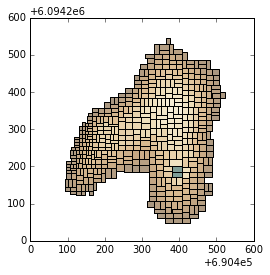

In [12]:
thepatches.plot(column='elevation',colormap='BrBG')

### Now collect the points from the same region

In [13]:
points_query = "with pts as(SELECT PC_Explode(pa) as pt FROM act8pt_16tiles_pc where PC_PatchAvg(pa, 'Z') > 800 ) select st_astext(pt::geometry) from pts;"

#get raw point data, not as a geometry
#points_query =  "SELECT PC_astext(PC_Explode(pa)) as pt FROM act_patches where PC_PatchAvg(pa, 'Z') > 700 ;"

%time pts = pdsql.read_sql(points_query, conn)

# point storage schema:
# 1 = intens, 2 = ReturnNo, 3 = Numreturns, 4 = scandirectionflag, 5 = edgeofflightline
# 6 = classification (ASPRS), 7 = scananglerank, 8 = user data, 9 = pointsourceID
# 10 = R, 11 = G, 12 = B, 13 = GPSTime, 14 = X, 15 = Y, 16 = Z

CPU times: user 1.18 s, sys: 455 ms, total: 1.64 s
Wall time: 1min 2s


In [14]:
#how many points did we get?
pts.size

2614969

In [15]:
#had to check the schema to find point order...
schema_query =  "SELECT * FROM pointcloud_formats where pcid = 4;"

schm = pdsql.read_sql(schema_query, conn)
print(schm.schema)

0    <?xml version="1.0" encoding="UTF-8"?>\n<pc:Po...
Name: schema, dtype: object


In [16]:
pts.head()

,st_astext
0,POINT Z (690512.12 6094324.59 797.18)
1,POINT Z (690512.18 6094324.59 798.41)
2,POINT Z (690516 6094324.59 797.85)
3,POINT Z (690508.06 6094324.59 796.28)
4,POINT Z (690509.03 6094324.59 798.5)


In [17]:
thepoints = []

for point in pts.st_astext:
    this = wkt_loads(point)
    thepoints.append([this.x,this.y,this.z])

In [18]:
thepoints = np.squeeze(thepoints)

### Plot the points

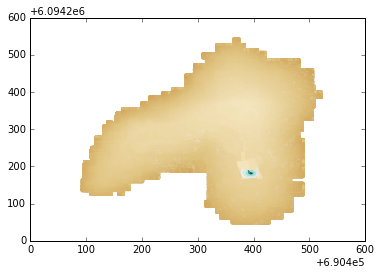

In [19]:
plt.scatter(thepoints[:,0], thepoints[:,1], c = thepoints[:,2], lw=0, s=5, cmap='BrBG')

### Now make a pretty plot - points, patches in the subset, and all the patches in the region

In [ ]:
fig = plt.figure()
fig.set_size_inches(25/2.51, 25/2.51)

BLUE = '#6699cc'
RED = '#cc6699'

ax = fig.gca() 
ax.scatter(thepoints[:,0], thepoints[:,1], c = thepoints[:,2], lw=0, s=3, cmap='BrBG')
for patch in thepatches.geom:
    ax.add_patch(PolygonPatch(patch, fc=BLUE, ec=BLUE, alpha=0.2, zorder=2 ))
    
for patch in thepatches.geom:
    ax.add_patch(PolygonPatch(patch, fc=BLUE, ec=RED, alpha=0.2, zorder=2 ))




## Selecting points by classification

In [21]:
#ASPRS class 6 - buildings
bldng_query = "WITH filtered_patch AS (SELECT PC_FilterEquals(pa, 'Classification', 6) as f_patch FROM act8pt_16tiles_pc where PC_PatchAvg(pa, 'Z') > 800) SELECT st_astext(point::geometry) FROM filtered_patch, pc_explode(f_patch) AS point;" 
%time bld_pts = pdsql.read_sql(bldng_query, conn)

CPU times: user 17.4 ms, sys: 8.4 ms, total: 25.8 ms
Wall time: 47.3 s


In [22]:
bld_pts.head()

bldpoints = []

for point in bld_pts.st_astext:
    this = wkt_loads(point)
    bldpoints.append([this.x,this.y,this.z])
bldpoints = np.squeeze(bldpoints)

In [23]:
#ASPRS class 2 - ground
grnd_query = "WITH filtered_patch AS (SELECT PC_FilterEquals(pa, 'Classification', 2) as f_patch FROM act8pt_16tiles_pc where PC_PatchAvg(pa, 'Z') > 800) SELECT st_astext(point::geometry) FROM filtered_patch, pc_explode(f_patch) AS point;" 
%time grnd_pts = pdsql.read_sql(grnd_query, conn)

CPU times: user 234 ms, sys: 111 ms, total: 346 ms
Wall time: 53.1 s


In [24]:
grnd_pts.head()

grndpoints = []

for point in grnd_pts.st_astext:
    this = wkt_loads(point)
    grndpoints.append([this.x,this.y,this.z])
grndpoints = np.squeeze(grndpoints)

In [25]:
#ASPRS class 5 - high vegetation
hv_query = "WITH filtered_patch AS (SELECT PC_FilterEquals(pa, 'Classification', 5) as f_patch FROM act8pt_16tiles_pc where PC_PatchAvg(pa, 'Z') > 800) SELECT st_astext(point::geometry) FROM filtered_patch, pc_explode(f_patch) AS point;" 
%time hv_pts = pdsql.read_sql(hv_query, conn)

CPU times: user 577 ms, sys: 204 ms, total: 780 ms
Wall time: 1min 3s


In [26]:
hv_pts.head()

hvpoints = []

for point in hv_pts.st_astext:
    this = wkt_loads(point)
    hvpoints.append([this.x,this.y,this.z])
hvpoints = np.squeeze(hvpoints)

NameError: name 'highpatches' is not defined

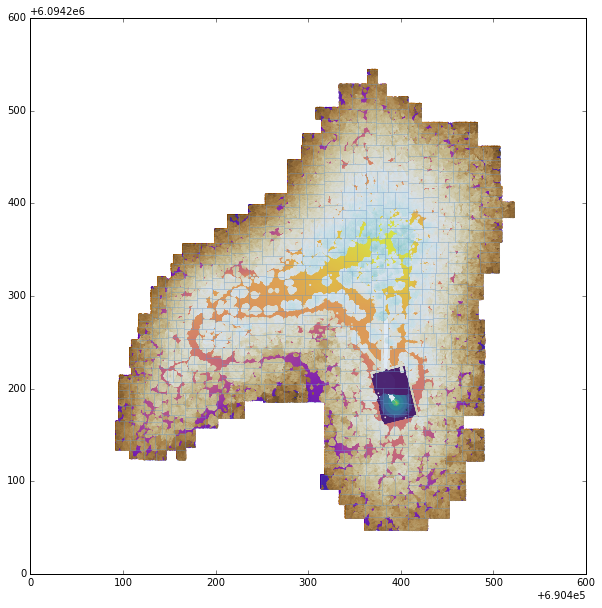

In [27]:
fig = plt.figure()
fig.set_size_inches(25/2.51, 25/2.51)

BLUE = '#6699cc'
RED = '#cc6699'

ax = fig.gca() 
ax.scatter(grndpoints[:,0], grndpoints[:,1], c = grndpoints[:,2], lw=0, s=3, cmap='plasma')
ax.scatter(bldpoints[:,0], bldpoints[:,1], c = bldpoints[:,2], lw=0, s=3, cmap='viridis')
ax.scatter(hvpoints[:,0], hvpoints[:,1], c = hvpoints[:,2], lw=0, s=3, cmap='BrBG')

for patch in thepatches.geom:
    ax.add_patch(PolygonPatch(patch, fc=BLUE, ec=BLUE, alpha=0.2, zorder=2 ))
    
for patch in highpatches.geom:
    ax.add_patch(PolygonPatch(patch, fc=BLUE, ec=RED, alpha=0.2, zorder=2 ))

### Add a 3D plot

In [28]:
#set up for 3d plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as pylab

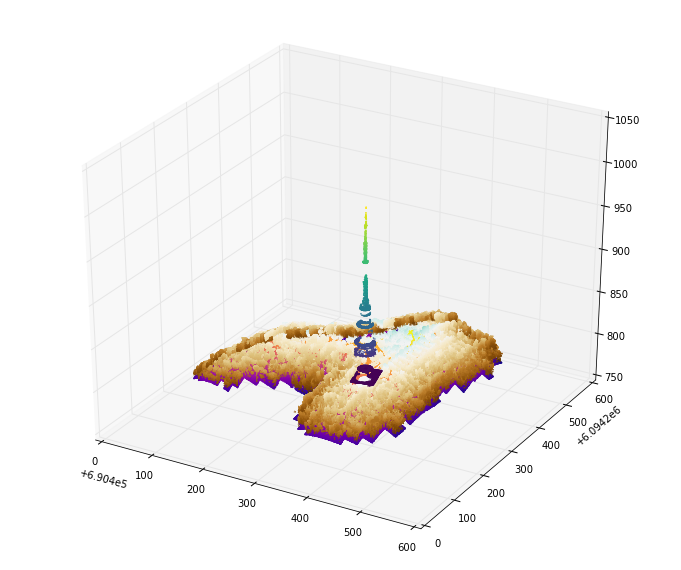

In [29]:
plt_az=300
plt_elev = 50.
plt_s = 2

cb_fmt = '%.1f'

fig = plt.figure()
fig.set_size_inches(30/2.51, 25/2.51)

ax0 = fig.add_subplot(111, projection='3d')
ax0.scatter(grndpoints[:,0], grndpoints[:,1],grndpoints[:,2], c=np.ndarray.tolist(grndpoints[:,2]),\
                lw=0, s=plt_s, cmap='plasma')
ax0.scatter(bldpoints[:,0], bldpoints[:,1],bldpoints[:,2], c=np.ndarray.tolist(bldpoints[:,2]),\
                lw=0, s=plt_s, cmap='viridis')
ax0.scatter(hvpoints[:,0], hvpoints[:,1],hvpoints[:,2], c=np.ndarray.tolist(hvpoints[:,2]),\
                lw=0, s=plt_s-1, cmap='BrBG')

### Export to three.js?

In [39]:
import vtk

ImportError: No module named 'vtk'

In [31]:
np.savetxt('ground_points_800.txt', grndpoints, delimiter=',')
np.savetxt('bld_points_800.txt', bldpoints, delimiter=',')
np.savetxt('hv_points_800.txt', hvpoints, delimiter=',')

### To do:

- too many things!
- select from database by:
    - class (demonstrated here)
    - height above ground (need to integrate PDAL and PCL)
    - tree cover
    - intersection with objects
- things on the list:
    - comparing LandSAT bare ground and LIDAR bare ground
    - tree heights and geophysical properties
    - ...

### All very cool but why?
National elevation maps - storing and managing many billions of points as a coherent dataset for precise elevation estimation. Also aiming to store provenance - if there's a data issue, we need more than just points. We need to figure out why the issue occurred, and fix it. We can also store things like point accuracy, some QC metrics, whatever point attributes we like! Or points from manifold sources:
- airborne LiDAR
- terrestrial scanners
- 3D photogrammetry
- geophysical datasets (already as points in netCDF)
- output of discrete element models (eg. Kool et al, or new sea ice models in development)